In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import holidays
from xgboost import XGBRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error

### 1. Przygotowanie danych i inżynieria cech

In [67]:
df = pd.read_excel('2019_PM25_1g.xlsx', skiprows=5)
print(df.head())

       Kod stanowiska  DsDusznikMOB-PM2.5-1g  DsJaworMOB-PM2.5-1g  \
0 2019-01-01 01:00:00               33.40530             51.38780   
1 2019-01-01 02:00:00               13.80280             28.49950   
2 2019-01-01 03:00:00                9.94056             11.12060   
3 2019-01-01 04:00:00                6.75889              5.57358   
4 2019-01-01 05:00:00                7.88722              6.56224   

   DsJelGorOgin-PM2.5-1g  DsWrocAlWisn-PM2.5-1g  DsWrocWybCon-PM2.5-1g  \
0               118.7730               102.0900               107.0610   
1               110.0640                63.6111                55.9187   
2               107.9410                48.3540                41.3488   
3                94.5489                34.6621                29.8697   
4                67.8800                14.2870                17.6000   

   KpBydPlPozna-PM2.5-1g  KpMogiNowMOB-PM2.5-1g  KpToruDziewu-PM2.5-1g  \
0                64.1177                    NaN                24.

Wybór stacji

In [68]:
df_rze = df[["Kod stanowiska", "PkRzeszPilsu-PM2.5-1g"]]
print(df_rze.head())

       Kod stanowiska  PkRzeszPilsu-PM2.5-1g
0 2019-01-01 01:00:00                34.7328
1 2019-01-01 02:00:00                26.0467
2 2019-01-01 03:00:00                25.3294
3 2019-01-01 04:00:00                28.2461
4 2019-01-01 05:00:00                31.9958


Zmiana nazewnicta kolumn

In [69]:
df_rze = df_rze.rename(columns={"Kod stanowiska": "Data Pomiaru", "PkRzeszPilsu-PM2.5-1g": "PM2.5"})
print(df_rze.head())

         Data Pomiaru    PM2.5
0 2019-01-01 01:00:00  34.7328
1 2019-01-01 02:00:00  26.0467
2 2019-01-01 03:00:00  25.3294
3 2019-01-01 04:00:00  28.2461
4 2019-01-01 05:00:00  31.9958


In [70]:
df_rze.set_index("Data Pomiaru", inplace=True)
print(df_rze.head())

                       PM2.5
Data Pomiaru                
2019-01-01 01:00:00  34.7328
2019-01-01 02:00:00  26.0467
2019-01-01 03:00:00  25.3294
2019-01-01 04:00:00  28.2461
2019-01-01 05:00:00  31.9958


Sprawdzenie typów kolumn

In [71]:
print(df_rze.dtypes)

PM2.5    float64
dtype: object


Wizualizacja danych na wykresie liniowym

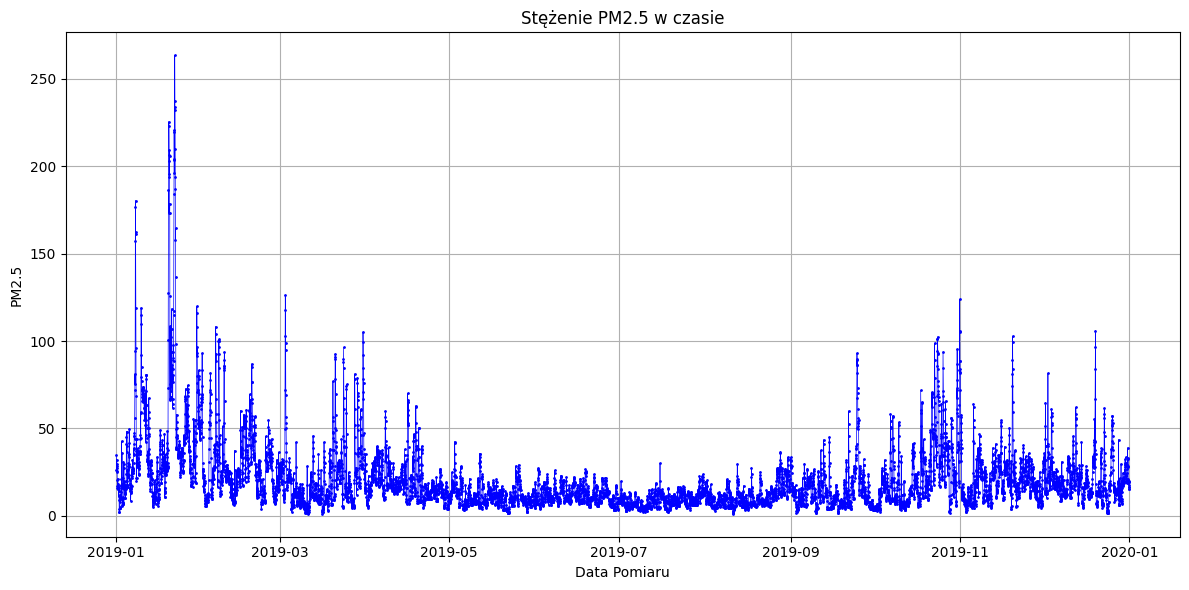

In [72]:
plt.figure(figsize=(12, 6))
plt.plot(df_rze.index, df_rze["PM2.5"], color='blue', marker='.', linewidth=0.5, markersize=2)
plt.xlabel("Data Pomiaru")
plt.ylabel("PM2.5")
plt.title("Stężenie PM2.5 w czasie")
plt.grid(True)
plt.tight_layout()
plt.show()

Detekcja wartości brakujących i zastąpienie ich wartością, wykorzystująć metodę interpolacyjną

In [73]:
print(df_rze.isna().sum())

PM2.5    11
dtype: int64


In [74]:
df_rze["PM2.5"] = df_rze["PM2.5"].interpolate(method="linear", limit_direction="both")
print(df_rze.isna().sum())

PM2.5    0
dtype: int64


Inżynieria cech - generowanie cech na podstawie kolumny z datą pomiaru (godzina, dzień tygodnia, miesiąc, wydzień, czy weekend, sinus i cosinus z godziny, sinus i cosinus z miesiąca, czy święto)

In [75]:
df_rze["hour"] = df_rze.index.hour
df_rze["weekday"] = df_rze.index.weekday
df_rze["month"] = df_rze.index.month
df_rze["week"] = df_rze.index.isocalendar().week
df_rze["weekend"] = df_rze.index.dayofweek >= 5
df_rze["hour_sin"] = np.sin(2 * np.pi * df_rze["hour"] / 24)
df_rze["hour_cos"] = np.cos(2 * np.pi * df_rze["hour"] / 24)
df_rze["month_sin"] = np.sin(2 * np.pi * df_rze["month"] / 12)
df_rze["month_cos"] = np.cos(2 * np.pi * df_rze["month"] / 12)
pl_holidays = holidays.Poland(years=2019)
df_rze["is_holiday"] = df_rze.index.normalize().isin(pl_holidays)
print(df_rze.head())

                       PM2.5  hour  weekday  month  week  weekend  hour_sin  \
Data Pomiaru                                                                  
2019-01-01 01:00:00  34.7328     1        1      1     1    False  0.258819   
2019-01-01 02:00:00  26.0467     2        1      1     1    False  0.500000   
2019-01-01 03:00:00  25.3294     3        1      1     1    False  0.707107   
2019-01-01 04:00:00  28.2461     4        1      1     1    False  0.866025   
2019-01-01 05:00:00  31.9958     5        1      1     1    False  0.965926   

                     hour_cos  month_sin  month_cos  is_holiday  
Data Pomiaru                                                     
2019-01-01 01:00:00  0.965926        0.5   0.866025        True  
2019-01-01 02:00:00  0.866025        0.5   0.866025        True  
2019-01-01 03:00:00  0.707107        0.5   0.866025        True  
2019-01-01 04:00:00  0.500000        0.5   0.866025        True  
2019-01-01 05:00:00  0.258819        0.5   0.86602

C:\Users\filip\AppData\Local\Temp\ipykernel_15244\416003201.py:11: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  df_rze["is_holiday"] = df_rze.index.normalize().isin(pl_holidays)


Wybrałem dosyć podstawowe cechy opisujące datę pomiaru, takie jak, godzina, miesiąc, dzień tygodnia. Nie zdecydowałem się na wybór roku, gdyż dane obejmują tylko rok 2019. Dodałem jeszcze cechy związane z weekendem i występowaniem świąt - może to wpływać na stężenie PM2.5. Wykorzystałem również funkcje trygonometryczne (sin i cos), aby opisać godzinę pomiaru i dzień miesiąca - może to być dosyć dobra informacja dla późniejszego modelowania.

Inzynieria cech - generowanie cech na podstawie przesunięć

In [76]:
# 1 godzina wstecz
df_rze["pm25_lag_1h"] = df_rze["PM2.5"].shift(1)

# 1 dzień wstecz
df_rze["pm25_lag_1d"] = df_rze["PM2.5"].shift(24)

# 1 tydzień wstecz
df_rze["pm25_lag_1w"] = df_rze["PM2.5"].shift(24 * 7)

# 1 godzina naprzód
df_rze["pm25_lead_1h"] = df_rze["PM2.5"].shift(-1)

# 1 dzień naprzód
df_rze["pm25_lead_1d"] = df_rze["PM2.5"].shift(-24)

# 1 tydzień naprzód
df_rze["pm25_lead_1w"] = df_rze["PM2.5"].shift(-24 * 7)

Inzynieria cech - generowanie cech na podstawie okien czasowych

In [ ]:
# Średnia z ostatnich 3 godzin
df_rze["pm25_roll_mean_3h"] = df_rze["PM2.5"].rolling(window=3).mean()

# Średnia z ostatnich 24 godzin
df_rze["pm25_roll_mean_24h"] = df_rze["PM2.5"].rolling(window=24).mean()

# Mediana z ostatnich 3 godzin
df_rze["pm25_roll_median_3h"] = df_rze["PM2.5"].rolling(window=3).median()

# Mediana z ostatnich 24 godzin
df_rze["pm25_roll_median_24h"] = df_rze["PM2.5"].rolling(window=24).median()

In [78]:
df_rze["pm25_roll_max_24h"] = df_rze["PM2.5"].rolling(window=24).max()
df_rze["pm25_roll_min_24h"] = df_rze["PM2.5"].rolling(window=24).min()

In [79]:
# Średnia z ostatnich 3 dni
df_rze["pm25_roll_mean_3days"] = df_rze["PM2.5"].rolling(window=3*24).mean()

# Średnia z ostatnich 7 dni
df_rze["pm25_roll_mean_7days"] = df_rze["PM2.5"].rolling(window=7*24).mean()

# Mediana z ostatnich 3 dni
df_rze["pm25_roll_median_3days"] = df_rze["PM2.5"].rolling(window=3*24).median()

# Mediana z ostatnich 7 dni
df_rze["pm25_roll_median_7days"] = df_rze["PM2.5"].rolling(window=7*24).median()

Cechy, które wybrałem to: średnia i mediana z 3 godzin, 24 godzin, 3 dni, 24 dni, a także wartości minimalne i maksymalne z danego dnia (24 godziny)

Podsumowanie cech do nauki modelu

In [80]:
df_rze.columns

Index(['PM2.5', 'hour', 'weekday', 'month', 'week', 'weekend', 'hour_sin',
       'hour_cos', 'month_sin', 'month_cos', 'is_holiday', 'pm25_lag_1h',
       'pm25_lag_1d', 'pm25_lag_1w', 'pm25_lead_1h', 'pm25_lead_1d',
       'pm25_lead_1w', 'pm25_roll_mean_3h', 'pm25_roll_mean_24h',
       'pm25_roll_median_3h', 'pm25_roll_median_24h', 'pm25_roll_max_24h',
       'pm25_roll_min_24h', 'pm25_roll_mean_3days', 'pm25_roll_mean_7days',
       'pm25_roll_median_3days', 'pm25_roll_median_7days'],
      dtype='object')

Czy jest możliwe uwzględnienienie czynnika przestrzennego w tworzeniu cech? 
Uwzględnienie czynnika przestrzennego w analizie PM2.5 jest możliwe i często wskazane. Stężenie tego aerozolu zwykle zależy od położenia czujnika. Przykładowo zdecydowanie inne wyniki pomiaru pokaże czujnik w Krakowie/Warszawie o 16 w dzień roboczy w porównianiu do czujnika nad Morzem Bałtyckim w tym samym dniu. W badanych danych nie uwzględniono czynnika przestrzennego, gdyż nie określono w nich położenia stacji (tylko nazwę).

Podział zbioru danych (train test split)

In [83]:
# 80 % do zbioru treningowego, 20 % do testowego
split_idx = int(len(df_rze) * 0.8)

# Podział
train = df_rze.iloc[:split_idx]
test = df_rze.iloc[split_idx:]

print(f"Train: od {train.index.min()} do {train.index.max()}")
print(f"Test:  od {test.index.min()} do {test.index.max()}")

Train: od 2019-01-01 01:00:00 do 2019-10-20 00:00:00
Test:  od 2019-10-20 01:00:00 do 2020-01-01 00:00:00


### 2. Tworzenie modelu do predykcji

Utworzenie zmiennych: X_train, y_train, X_test, y_test

In [84]:
X = df_rze.drop(columns=["PM2.5"])
y = df_rze["PM2.5"]

In [89]:
X_train = X.iloc[:split_idx]
X_test = X.iloc[split_idx:]
y_train = y.iloc[:split_idx]
y_test = y.iloc[split_idx:]

Inicjalizacja modelu, trenowanie, Predykcja

In [96]:
model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=42)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse:.2f}")

Mean Squared Error: 10.43


| Plusy XGBoost                                   | Minusy XGBoost                                                 |
| ----------------------------------------------- | -------------------------------------------------------------- |
| Bardzo dobra wydajność na danych tabularycznych | Nie modeluje zależności czasowych bez inżynierii cech          |
| Obsługuje brakujące dane (NaN)                  | Nie działa na surowych sekwencjach jak RNN/LSTM                |
| Szybki trening i predykcja                      | Brak wbudowanej pamięci sekwencyjnej (historia = cechy)        |
| Odporność na przeuczenie (dzięki regularizacji) | Trudniej modelować trendy długoterminowe                       |
| Łatwa interpretowalność cech                    | Nie nadaje się do bardzo gęstych danych sekwencyjnych          |
| Można tuningować parametry precyzyjnie          | Wymaga ręcznego podziału danych czasowych                      |


Tuning hiperparametrów

Hiperparametry to ustawienia/cechy/parametry zewnętrzne modelu, które nie są uczone automatycznie podczas treningu, a ustawione ręcznie przez kreatora modelu przed treningiem. Wpływają one na ogólny wynik, kondycję i skuteczność modelu.
Hiperparametry wymagają tuningu z kilku powodów:
- Bo mają ogromny wpływ na skuteczność modelu
- Źle dobrane hiperparametry powodują nadmierne dopasowanie (overfitting) lub niedouczenie (underfitting)
- Dobrze dobrane hiperparametry powodują lepsze wyniki/metryki modelu

Przykładowe hiperparametry w kontekście modelu XGBoost:

| Hiperparametr               | Definicja                                  |
| --------------------------- | ------------------------------------------ |
| n_estimators                | Liczba drzew                               |
| max_depth                   | Maksymalna głębokość drzewa                |
| learning_rate               | Jak szybko uczą się kolejne drzewa         |
| subsample                   | Procent próbek używanych do każdego drzewa |
| colsample_bytree            | Procent cech używanych do każdego drzewa   |

In [ ]:
tscv = TimeSeriesSplit(n_splits=5) # 5-fold-ów

# Siatka hiperparametrów
param_grid = {
    'n_estimators': [50, 100, 200, 500, 1000],
    'max_depth': [3, 4, 5, 10],
    'learning_rate': [0.01, 0.02, 0.05, 0.1],
}

# Model
model = XGBRegressor(random_state=42)

# GridSearchCV z TimeSeriesSplit
grid_search = GridSearchCV(
    estimator=model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Najlepsze hiperparametry:")
print(grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE na zbiorze testowym: {rmse:.2f}")

Fitting 5 folds for each of 80 candidates, totalling 400 fits
Najlepsze hiperparametry:
{'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1000}
RMSE na zbiorze testowym: 3.35


### Backtesting 

Podział na okna czasowe i ocena wydajności

Walidacja czasowa to technika, gdy ma się do czynienia z danymi szeregowymi (typu time series). W przeciwieństwie do klasycznego podziału, czas ma znaczenie – nie można mieszać przeszłości z przyszłością. Dlatego stosuje się techniki takie jak: walk-forward, roll-forward, czy gap-roll-forward validation.
Ogólnie walidacja polega na przesuwaniu okna z danymi, które występują w czasie, tak jak będzie to ma miejsce w rzeczywistości (chrnologicznie). Dane czasowe często mają sezonowość, zmienność trendów itp. Takie podejście pozwala sprawdzić, czy model działa równie dobrze na różnych oknach czasowych.

Wybrano Gap Roll-Forward Validation do przeprowadzenia walidacji czasowej

In [ ]:
# Parametry okien 
n_splits = 5
test_size = 24 * 30     # 1 miesiąc danych godzinowych
train_size = 24 * 180   # 6 miesięcy
gap = 24 * 7            # 1 tydzień przerwy

rmses = []

for i in range(n_splits):
    train_start = i * test_size
    train_end = train_start + train_size
    test_start = train_end + gap
    test_end = test_start + test_size

    if test_end > len(X):
        break

    X_train_fold = X.iloc[train_start:train_end]
    y_train_fold = y.iloc[train_start:train_end]
    X_test_fold = X.iloc[test_start:test_end]
    y_test_fold = y.iloc[test_start:test_end]

    model = XGBRegressor(
        learning_rate=0.01,
        max_depth=4,
        n_estimators=1000,
        random_state=42,
        verbosity=0
    )

    model.fit(X_train_fold, y_train_fold)
    y_pred = model.predict(X_test_fold)
    rmse = np.sqrt(mean_squared_error(y_test_fold, y_pred))
    rmses.append(rmse)
    print(f"Split {i+1}, RMSE: {rmse:.2f}")

print(f"\nŚrednie RMSE z walidacji czasowej: {np.mean(rmses):.2f}")

Split 1, RMSE: 1.02
Split 2, RMSE: 1.23
Split 3, RMSE: 2.02
Split 4, RMSE: 6.87
Split 5, RMSE: 3.18

Średnie RMSE z walidacji czasowej: 2.86


Niskie RMSE w pierwszych 3 splitach, Split 4 — duży skok RMSE (6.87), Split 5 — lekkie obniżenie RMSE (3.18)

Backtesting uwzględnia czas i testuje model tak, jakby działał w czasie rzeczywistym, gdzie przyszłość jest niedostępna.

Klasyczne testowanie wydajności zakłada niezależność próbek i zwykle opiera się na losowym podziale danych, co nie sprawdza się w analizie szeregów czasowych.

### 4.  Analiza istotności cech

Wyliczenie istotności cech

In [100]:
importance = model.feature_importances_

In [105]:
df_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)

print(df_imp)

                   Feature  Importance
16       pm25_roll_mean_3h    0.571456
13            pm25_lead_1h    0.254990
18     pm25_roll_median_3h    0.120813
10             pm25_lag_1h    0.011730
20       pm25_roll_max_24h    0.004890
22    pm25_roll_mean_3days    0.002892
0                     hour    0.002737
6                 hour_cos    0.002725
24  pm25_roll_median_3days    0.002658
15            pm25_lead_1w    0.002574
21       pm25_roll_min_24h    0.002528
1                  weekday    0.002478
5                 hour_sin    0.002010
11             pm25_lag_1d    0.001966
17      pm25_roll_mean_24h    0.001741
12             pm25_lag_1w    0.001732
23    pm25_roll_mean_7days    0.001632
25  pm25_roll_median_7days    0.001554
19    pm25_roll_median_24h    0.001401
3                     week    0.001372
14            pm25_lead_1d    0.001317
7                month_sin    0.001147
2                    month    0.001071
8                month_cos    0.000586
9               is_holida

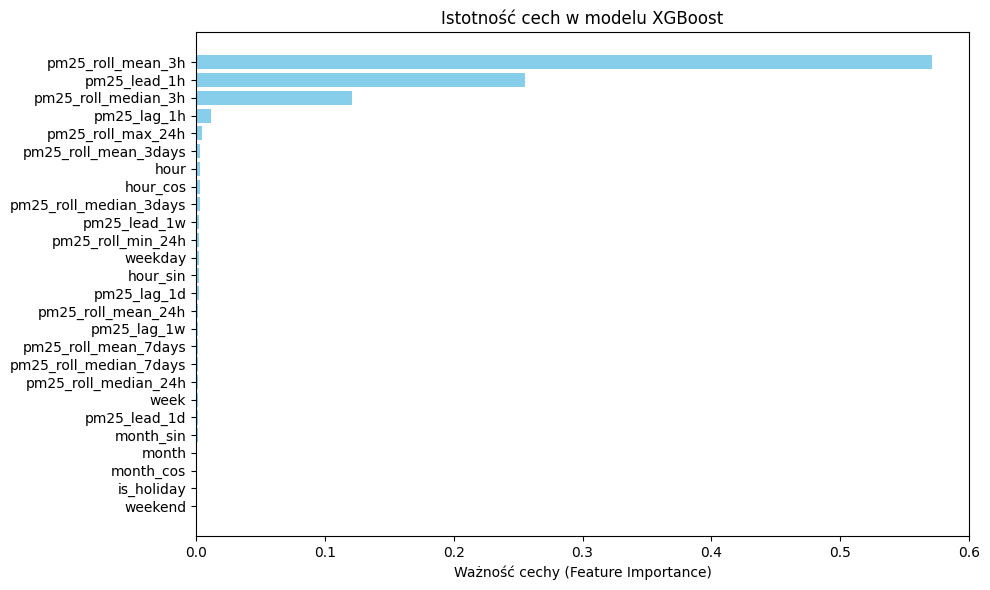

In [106]:
plt.figure(figsize=(10, 6))
plt.barh(df_imp['Feature'], df_imp['Importance'], color='skyblue')
plt.xlabel("Ważność cechy (Feature Importance)")
plt.title("Istotność cech w modelu XGBoost")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

3 cechy wyróżniły się wysoką wartością feature importance. Są to:
- średnia dla okien 3 godzinnych
- wartość PM2.5 następującą godzinę po pomiarze (kolejny pomiar)
- mediana dla okien 3 godzinnych

Reszta cech nie była jakoś bardzo istotna dla modelowania. Najsłabiej wypadły echy mówiące o weekendzie, świętach, trygonometryczne funkcje miesiąca.

Wnioski z badania istotności cech:
- Model bardzo silnie opiera się na krótkoterminowych trendach PM2.5, pm25_roll_mean_3h i pm25_roll_median_3h odpowiadają razem za prawie 70% istotności. Oznacza to, że ostatnie godziny są najbardziej przewidywalne dla przyszłych stężeń
- Prawdopodobnie sezonowość lub dzień tygodnia nie mają dużego wpływu na PM2.5 na model
- Niektóre cechy (weekend, holiday) mają wartość 0, to oznacza, że model ich w ogóle nie używa, mogą być nieistotne